In [18]:
# Setup Warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Global imports
import csv
import cv2
import json
import matplotlib as mlp
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random
import re
import seaborn as sns

# Typing import
from typing import List, Dict, Union, Tuple

# Specific imports
from copy import deepcopy
from matplotlib.patches import Rectangle, Ellipse
from matplotlib.animation import FuncAnimation, PillowWriter
from rich import print
from termcolor import cprint
from time import time

# Local imports
from loading import csv_to_dict

sns.set_theme('notebook')
sns.set_style("whitegrid")
sns.set_context("paper")
sns.color_palette("hls", 8)

def print_bl():
    print("\n")


def print_red(*args):
    for arg in args:
        cprint(arg, "red", end=' ')  # Using end=' ' to print all arguments on the same line
    print()

def print_green(*args):
    for arg in args:
        cprint(arg, "green", end=' ')  # Using end=' ' to print all arguments on the same line
    print()

def print_highlight(*args):
    for arg in args:
        cprint(arg, "magenta", "on_white", end=' ')  # Using end=' ' to print all arguments on the same line
    print()

def print_blue(*args):
    for arg in args:
        cprint(arg, "light_blue", end=' ')  # Using end=' ' to print all arguments on the same line
    print()


Group definition:
- 1 second sampling rate.
- In any scene, choose an ego vehicle __outside__ of the roundabout. That is the ego vehicle.
    - Sample the database until the ego vehicle enters the roundabout
    - If window length is short, resample the same scene with another ego_vehicle. If there are not any suitable vehicles, move on.
- Max window length: 5 seconds.

Refer all coordinates to the center of the roundabout. Perform calculations in pixels and then convert to meters using OrthoPxToMeter*10.

In [23]:
class RounDGroupExtractor:
    """
    A class that extracts vehicle groups from a highD dataset recording
    
    Attributes:
        dataset_location: a path to the directory in which the dataset is stored.
        dataset_index: index of the recording that is to be addressed
        data: the raw data of the recording.
        static_info: the static information of the recording.
        video_info: the video information of the recording.

    Methods:        
        get_background_img: sets the background image for plotting, creating gifs, and calculating roundabout geometry.
    """
    def __init__(self, dataset_location: str = None, dataset_index: int = None) -> None:
        """
        Initializes the RounDGroupExtractor class for a specific dataset recording.

        Args:
            dataset_location (str): The path to the directory where the dataset is stored.
            dataset_index (int): The index of the recording to be addressed (should be between 1 and 22).

        Initializes the background image, roundabout geometry (center, inner/outer radius), and entry/exit points.
        Entry and exit points are transformed to match the current image using homography.
        """
        ### Error handling
        if dataset_location is None:
            raise ValueError("Please provide a dataset location.")
        if dataset_index is None or dataset_index < 1 or dataset_index > 22:
            raise ValueError("Please provide a dataset index between 1 and 22")
        
        # Reference points for homography
        self.reference_exit_points = {'north': (961,238), 'south': (645, 695), 'east': (1053, 590), 'west': (550, 354)}
        self.reference_entry_points = {'north': (880, 195), 'south': (724, 735), 'east': (1083, 503), 'west': (528, 439)}
        self.reference_rotation_angle = 14.25

        # Entry and exit points for the current image - Initialized in get_entry_exit_points
        self.entry_points = {}
        self.exit_points = {}
        self.rotation_angle = 0.0

        # retrieve raw data
        self.dataset_index  = dataset_index
        self.dataset_location = dataset_location
        self.df_location = dataset_location + str(dataset_index).zfill(2) + "_tracks.csv"
        self.static_info_location = dataset_location + str(dataset_index).zfill(2) + "_tracksMeta.csv"
        self.video_info_location = dataset_location + str(dataset_index).zfill(2) + "_recordingMeta.csv"
        self.reference_image_path = dataset_location + '00_background.png'
        self.image_path = dataset_location + f'{str(dataset_index).zfill(2)}_background.png'

        self.data = pd.read_csv(self.df_location)
        self.static_info = pd.read_csv(self.static_info_location)
        self.video_info = csv_to_dict(self.video_info_location)

        self.frame_length = 1000/self.video_info["frameRate"] # Measured in miliseconds

        self.get_background_img(self.image_path)
        self.center_x_px, self.center_y_px, self.outer_radius_px, self.inner_radius_px = self.get_roundabout_edges()
        self.entry_points_px, self.exit_points_px = self.get_entry_exit_points()

        # Convert pixel values to meters
        self.center_x_m = self.center_x_px * self.bg_image_scaling_factor
        self.center_y_m = -self.center_y_px * self.bg_image_scaling_factor
        self.outer_radius_m = self.outer_radius_px * self.bg_image_scaling_factor
        self.inner_radius_m = self.inner_radius_px * self.bg_image_scaling_factor
        self.entry_points_m = {key: (point[0] * self.bg_image_scaling_factor, -point[1] * self.bg_image_scaling_factor) for key, point in self.entry_points_px.items()}
        self.exit_points_m = {key: (point[0] * self.bg_image_scaling_factor, -point[1] * self.bg_image_scaling_factor) for key, point in self.exit_points_px.items()}

        # print_green(f"Roundabout center: ({self.center_x_m:.2f}, {self.center_y_m:.2f}) m")
        # print_green(f"Roundabout outer radius: {self.outer_radius_m:.2f} m")
        # print_green(f"Roundabout inner radius: {self.inner_radius_m:.2f} m")

        ## Initialize parameters
        self.sampling_period = None
        self.frame_spacing = None
        self.raw_frames = None
        self.framing_dict = None
 
    def get_background_img(self, path) -> None:
        """
        Loads the background image for plotting and analysis.

        Args:
            path (str): Path to the PNG image file containing the background image.

        Raises:
            FileNotFoundError: If the background image is not found at the specified path.

        Initializes the image scaling factor (meters per pixel) using data from the video information. From experimentation, this factor needs to be multiplied by 10 to match the roundabout geometry.
        """
        ### Error handling
        if not os.path.exists(path):
            raise FileNotFoundError(f"Background image not found at {path}.")
        self.bg_image = cv2.imread(path)
        self.bg_image_scaling_factor = self.video_info["orthoPxToMeter"]*10 # Measured in meters per pixel

    def get_roundabout_edges(self) -> Tuple[int, int, int, int]:
        """
        Detects the outer and inner edges of the roundabout using HoughCircles.

        Returns:
            Tuple[int, int, int, int]: The X and Y coordinates of the roundabout center, 
                                    and the radii of the outer and inner circles, respectively.

        Raises:
            ValueError: If no outer or inner edge is detected.
        """

        gray = cv2.cvtColor(self.bg_image, cv2.COLOR_BGR2GRAY)
        blurred = cv2.GaussianBlur(gray, (9, 7), 0)

        # Use HoughCircles to detect the roundabout's outer edge
        outer_circles = cv2.HoughCircles(
            blurred, cv2.HOUGH_GRADIENT, dp=1.2, minDist=1000,
            param1=100, param2=30, minRadius=200, maxRadius=300
        )

        if outer_circles is not None:
            outer_circles = np.round(outer_circles[0, :]).astype("int")
            largest_circle = max(outer_circles, key=lambda x: x[2])  # Select the largest circle (outer edge)
            center_x, center_y, outer_radius = largest_circle

            # Detect inner edge using a smaller radius range
            inner_circles = cv2.HoughCircles(
                blurred, cv2.HOUGH_GRADIENT, dp=1.2, minDist=300,
                param1=100, param2=30, minRadius=100, maxRadius=outer_radius - 50
            )

            if inner_circles is not None:
                inner_circles = np.round(inner_circles[0, :]).astype("int")
                inner_center_x, inner_center_y, inner_radius = min(inner_circles, key=lambda x: abs(x[0] - center_x))
                return center_x, center_y, outer_radius, inner_radius

        raise ValueError("No outer or inner edge detected.")

    def get_entry_exit_points(self) -> Tuple[Dict[str, Tuple[int, int]], Dict[str, Tuple[int, int]]]:
        """
        Calculates the entry and exit points of the roundabout based on homography.

        Returns:
            tuple: Two dictionaries containing the entry and exit points.
        """
        reference_image = cv2.imread(self.reference_image_path)
        current_image = cv2.imread(self.image_path)

        gray_reference = cv2.cvtColor(reference_image, cv2.COLOR_BGR2GRAY)
        gray_current = cv2.cvtColor(current_image, cv2.COLOR_BGR2GRAY)

        # Feature matching with SIFT
        sift = cv2.SIFT_create()
        kp_ref, des_ref = sift.detectAndCompute(gray_reference, None)
        kp_cur, des_cur = sift.detectAndCompute(gray_current, None)

        bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
        matches = bf.match(des_ref, des_cur)
        matches = sorted(matches, key=lambda x: x.distance)

        ref_pts = np.float32([kp_ref[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
        cur_pts = np.float32([kp_cur[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)

        # Compute homography matrix
        H, _ = cv2.findHomography(ref_pts, cur_pts, cv2.RANSAC, 5.0)

        self.rotation_angle = np.atan2(H[0, 1], H[0, 0]) * 180 / np.pi + self.reference_rotation_angle

        reference_entry_points = np.float32(list(self.reference_entry_points.values())).reshape(-1, 1, 2)
        reference_exit_points = np.float32(list(self.reference_exit_points.values())).reshape(-1, 1, 2)

        transformed_entry_points = cv2.perspectiveTransform(reference_entry_points, H)
        transformed_exit_points = cv2.perspectiveTransform(reference_exit_points, H)

        entry_points = {key: tuple(point[0]) for key, point in zip(self.reference_entry_points.keys(), transformed_entry_points)}
        exit_points = {key: tuple(point[0]) for key, point in zip(self.reference_exit_points.keys(), transformed_exit_points)}

        return entry_points, exit_points

    def plot_roundabout_geometry_and_points(self, rotate: bool = False) -> None:
        """
        Plots the roundabout geometry and entry/exit points.

        Rotates the image if specified.

        Args:
            rotate (bool): Whether to rotate the image to align the roundabout arms with the x-axis.
        """
        ## Error handling
        if not hasattr(self, "center_x_px"):
            raise ValueError("Please call the get_roundabout_edges method first.")
        if not hasattr(self, "entry_points_px"):
            raise ValueError("Please call the get_entry_exit_points method first.")

        # Draw final roundabout geometry and entry/exit points
        plt.figure(figsize=(10, 8))
        result_image = self.bg_image.copy()
        cv2.circle(result_image, (self.center_x_px, self.center_y_px), self.outer_radius_px, (0, 255, 0), 4)  # Outer circle
        cv2.circle(result_image, (self.center_x_px, self.center_y_px), self.inner_radius_px, (255, 0, 0), 4)  # Inner circle
        cv2.circle(result_image, (self.center_x_px, self.center_y_px), 5, (0, 0, 255), -1)  # Center point

        # Mark entry and exit points
        for point in self.exit_points_px.values():
            cv2.circle(result_image, tuple(np.int32(point)), 10, (255, 0, 0), -1)  # Red for entry points - colors in BGR format
        for point in self.entry_points_px.values():
            cv2.circle(result_image, tuple(np.int32(point)), 10, (0, 0, 255), -1)  # Blue for exit points - colors in BGR format

        # Rotate the image if specified
        if rotate:
            print("Rotating image {} degrees counterclockwise to align the roundabout arms with the x-axis.".format(self.rotation_angle))
            w,h = result_image.shape[1], result_image.shape[0]
            M = cv2.getRotationMatrix2D((w/2,h/2), self.rotation_angle, 1)
            result_image = cv2.warpAffine(result_image, M, (w,h))
            
        # Display the final image with the geometry and points
        plt.imshow(cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB))
        plt.title("Roundabout Geometry with Entry (Red) and Exit (Blue) Points")
        plt.axis('off')
        plt.show()
    
    def in_roundabout(self, x: float, y: float) -> bool:
        """
        Checks if a point is inside the roundabout.
        
        Args:
            x (float): X-coordinate of the point.
            y (float): Y-coordinate of the point.
        
        Returns:
            bool: True if the point is inside the roundabout, False otherwise.
        """
        distance_to_center = np.linalg.norm(np.array([x, y]) - np.array([self.center_x_m, self.center_y_m]))
        return self.inner_radius_m <= distance_to_center <= self.outer_radius_m
    
    def filter_data(self, sampling_period: int = 1000) -> pd.DataFrame:
        """
        Filters the dataset with a certain sampling period.

        Args:
            sampling_period (int): The time spacing between each frame to consider. Measured in ms.
        Returns:
            The filtered dataset in the form of a pandas dataframe.
        """
        ### Argument validation
        if sampling_period % self.frame_length != 0:
            raise ValueError("Sampling period must be a multiple of 40ms.")
        
        self.sampling_period = sampling_period
        self.frame_spacing = int(self.sampling_period / self.frame_length) #Frames are 40 ms apart

        ### Printing parameters
        print("Filtering data with the following parameters:")
        print_green(f"Sampling period: {self.sampling_period} ms")
        print_green(f"Frame spacing: {self.frame_spacing} frames")

        self.data = self.data[self.data.frame % self.frame_spacing == 0]
        self.raw_frames = deepcopy(self.data.frame) # copy the old frame numbering for animation purposes
        self.data.frame = self.data.frame / self.frame_spacing
        self.framing_dict = dict(zip(self.data.frame, self.raw_frames)) # create a dictionary to convert old frame numbering to new frame numbering
        self.data = self.data.astype({'frame': 'int16'})

        return self.data
    
    def translate(self) -> None:
        """
        Translates the data to the center of the roundabout and performs a rotation to align the arms of the roundabout with the x-axis.

        From visual inspection, the data needs to be rotated 14.25 degrees counterclockwise.
        """
        ### Error handling
        if not hasattr(self, "center_x_m"):
            raise ValueError("Please call the get_roundabout_edges method first.")
        if not hasattr(self, "framing_dict"):
            raise ValueError("Please filter the data first.")
        
        # Translate the x and y coordinates
        self.data['xCenter'] = self.data['xCenter']*self.bg_image_scaling_factor - self.center_x_m
        self.data['yCenter'] = self.data['yCenter']*self.bg_image_scaling_factor - self.center_y_m

        # # Rotate the data
        # angle = np.radians(14.25)
        # rotation_matrix = np.array([np.cos(angle), -np.sin(angle)], [np.sin(angle), np.cos(angle)])
        # self.data[['x', 'y']] = self.data[['x', 'y']].dot(rotation_matrix)

    def find_vehicles_about_to_enter(self, entry_radius: float = 5.0) -> Dict[int, int]:
        """
        Finds vehicles that are about to enter the roundabout based on their proximity
        to the entry points. Stores their vehicle ID and the first frame they appear.

        Args:
            entry_radius (float): The radius around the entry points to consider for proximity. Measured in meters.

        Returns:
            entry_vehicles (Dict[int, int]): A dictionary where the keys are vehicle IDs
                                            and the values are the first frame they appear.
        """
        entry_vehicles = {}  # Dictionary to store vehicle ID and first frame
        
        # Iterate through the dataset to check each vehicle's position relative to the entry points
        for _, vehicle in self.data.iterrows():
            vehicle_id = vehicle['id']
            frame = vehicle['frame']
            vehicle_position = (vehicle['xCenter'], vehicle['yCenter'])
            
            # Check if the vehicle is near any of the entry points
            for entry_name, entry_point in self.entry_points_px.items():
                distance_to_entry = np.linalg.norm(np.array(vehicle_position) - np.array(entry_point))
                
                # If the vehicle is close to the entry point and it's the first time it's seen, store it
                if distance_to_entry < self.entry_radius:  # Define entry_radius to control proximity
                    if vehicle_id not in entry_vehicles:
                        entry_vehicles[vehicle_id] = frame  # Store the first frame they appear

        return entry_vehicles

                

## RounD Group extraction

Processing dataset 1

Rotating image 14.249999999999865 degrees counterclockwise to align the roundabout arms with the x-axis.

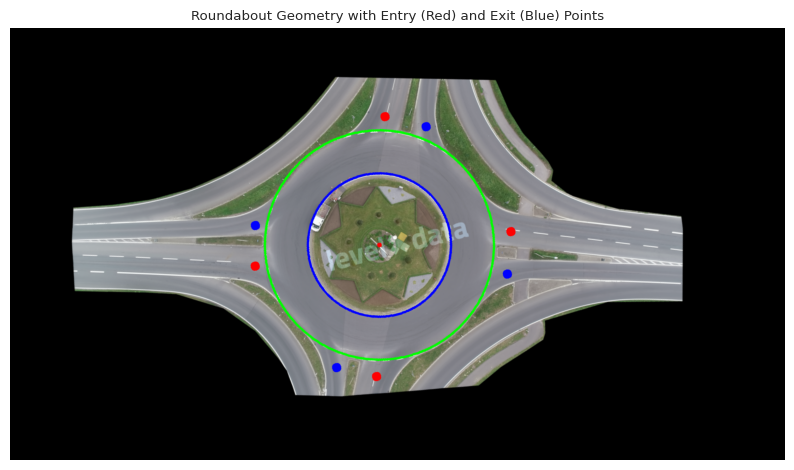

Filtering data with the following parameters:

Sampling period: 1000 ms 

Frame spacing: 25 frames 

Processing dataset 2

Rotating image 14.398452094065393 degrees counterclockwise to align the roundabout arms with the x-axis.

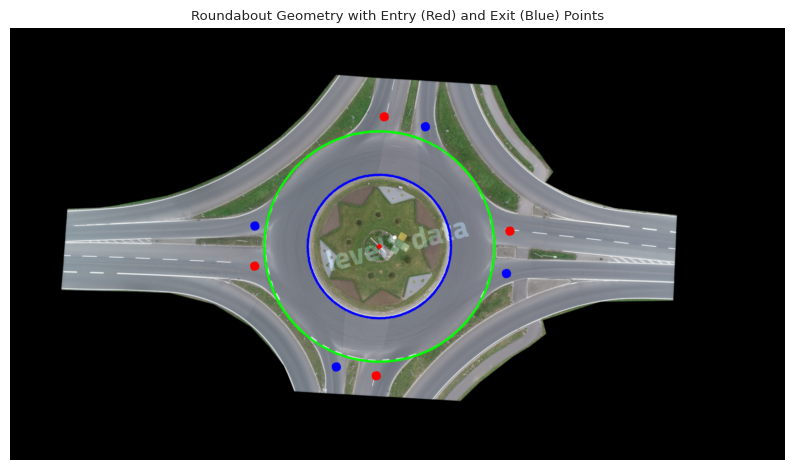

Filtering data with the following parameters:

Sampling period: 1000 ms 

Frame spacing: 25 frames 

Processing dataset 3

Rotating image 14.635943754370315 degrees counterclockwise to align the roundabout arms with the x-axis.

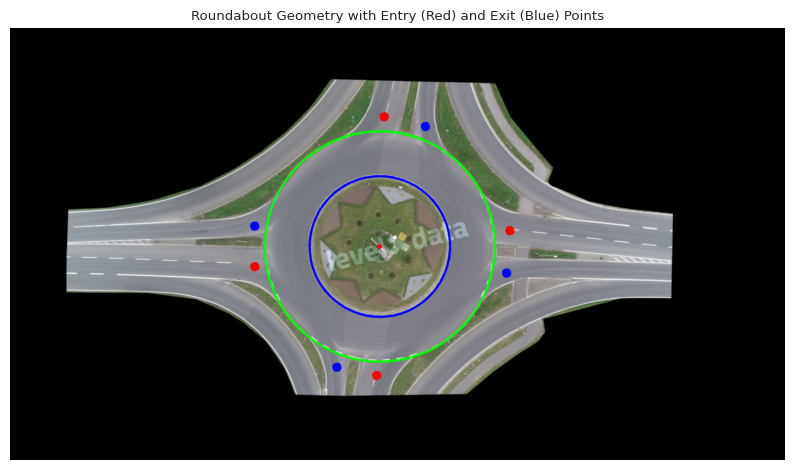

Filtering data with the following parameters:

Sampling period: 1000 ms 

Frame spacing: 25 frames 

Processing dataset 4

Rotating image 14.104910931764627 degrees counterclockwise to align the roundabout arms with the x-axis.

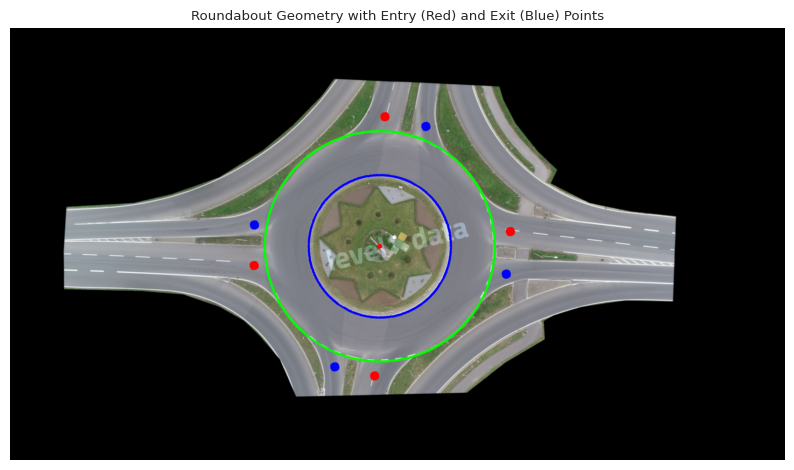

Filtering data with the following parameters:

Sampling period: 1000 ms 

Frame spacing: 25 frames 

Processing dataset 5

Rotating image 14.220800341465191 degrees counterclockwise to align the roundabout arms with the x-axis.

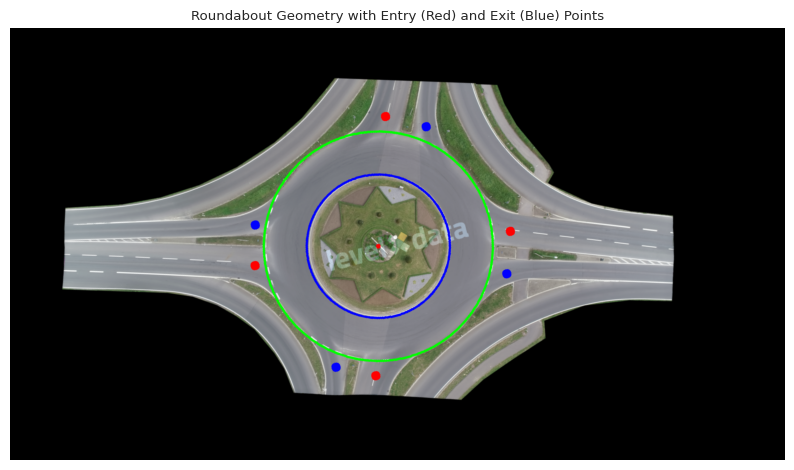

Filtering data with the following parameters:

Sampling period: 1000 ms 

Frame spacing: 25 frames 

Processing dataset 6

Rotating image 13.593467667643296 degrees counterclockwise to align the roundabout arms with the x-axis.

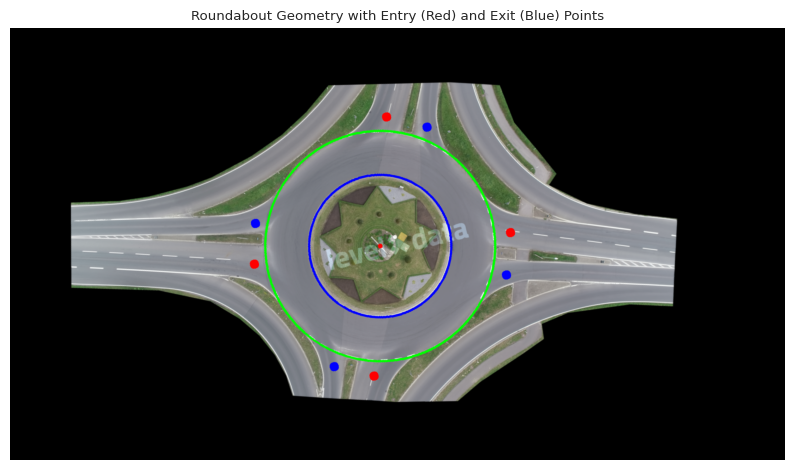

Filtering data with the following parameters:

Sampling period: 1000 ms 

Frame spacing: 25 frames 

Processing dataset 7

Rotating image 14.376046091600855 degrees counterclockwise to align the roundabout arms with the x-axis.

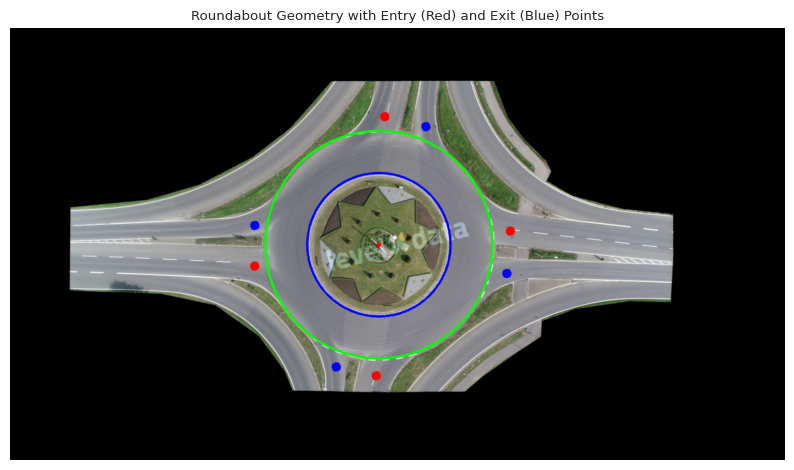

Filtering data with the following parameters:

Sampling period: 1000 ms 

Frame spacing: 25 frames 

Processing dataset 8

Rotating image 15.449524572560648 degrees counterclockwise to align the roundabout arms with the x-axis.

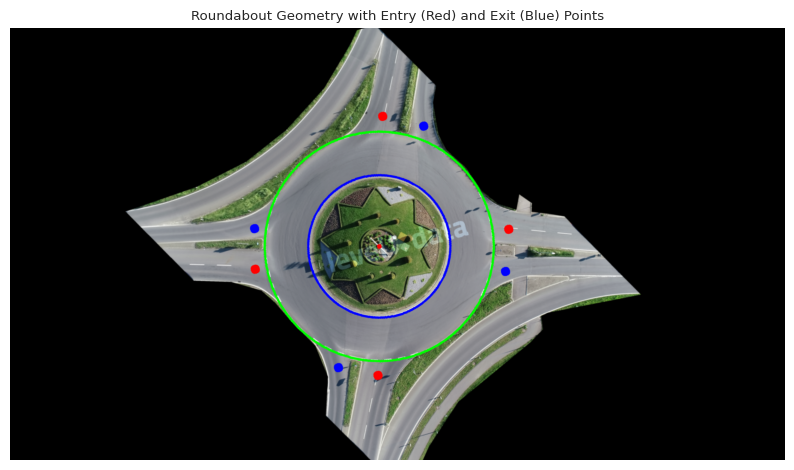

Filtering data with the following parameters:

Sampling period: 1000 ms 

Frame spacing: 25 frames 

Processing dataset 9

Rotating image 14.88918524347468 degrees counterclockwise to align the roundabout arms with the x-axis.

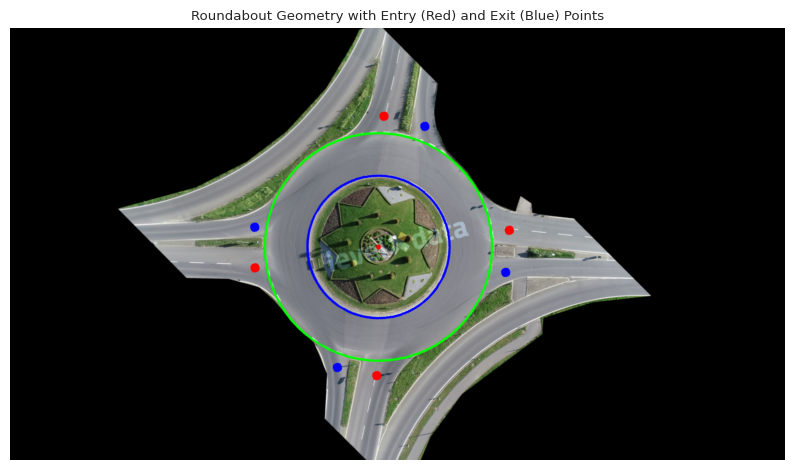

Filtering data with the following parameters:

Sampling period: 1000 ms 

Frame spacing: 25 frames 

Processing dataset 10

Rotating image 14.926353339857888 degrees counterclockwise to align the roundabout arms with the x-axis.

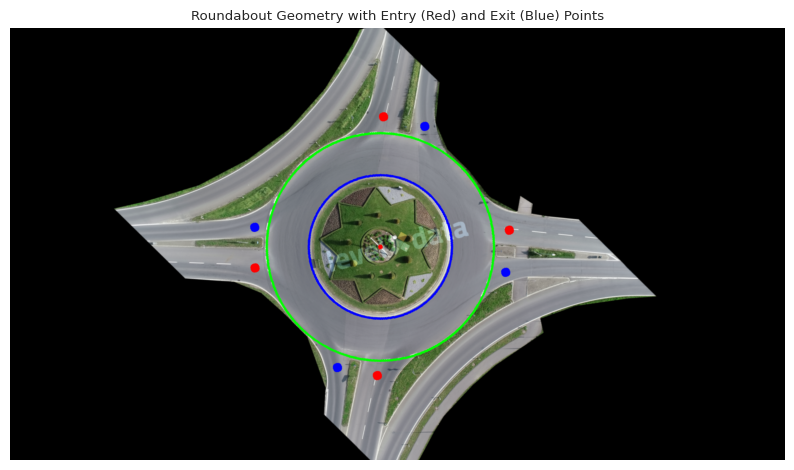

Filtering data with the following parameters:

Sampling period: 1000 ms 

Frame spacing: 25 frames 

Processing dataset 11

Rotating image 15.040330068910563 degrees counterclockwise to align the roundabout arms with the x-axis.

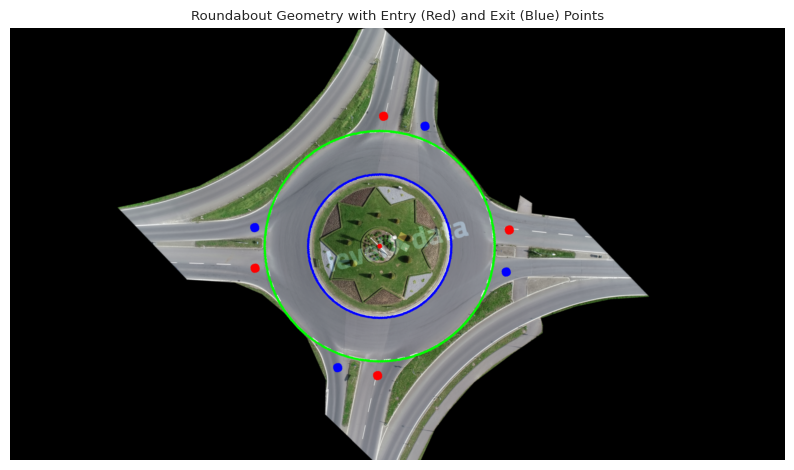

Filtering data with the following parameters:

Sampling period: 1000 ms 

Frame spacing: 25 frames 

Processing dataset 12

Rotating image 15.038066437301488 degrees counterclockwise to align the roundabout arms with the x-axis.

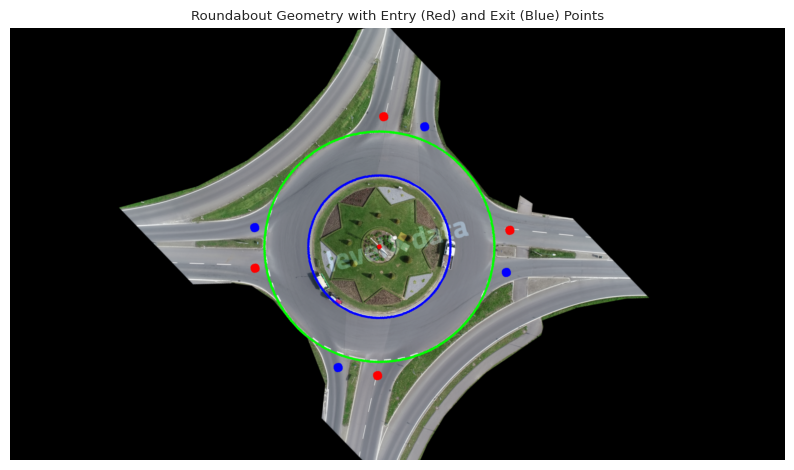

Filtering data with the following parameters:

Sampling period: 1000 ms 

Frame spacing: 25 frames 

Processing dataset 13

Rotating image 14.656649135057254 degrees counterclockwise to align the roundabout arms with the x-axis.

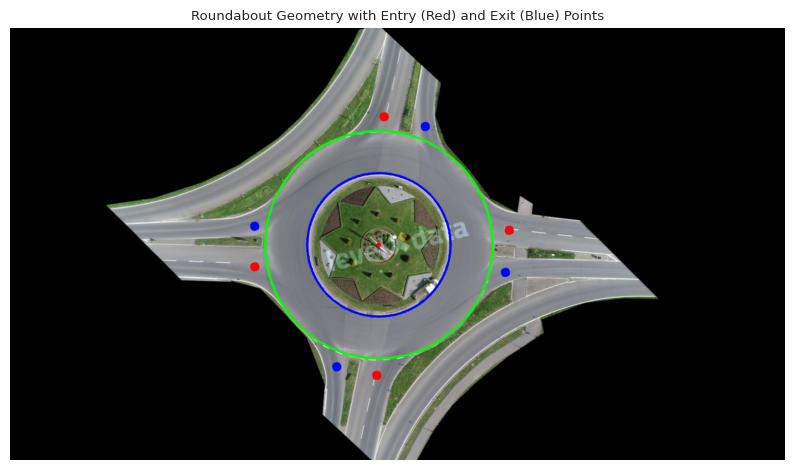

Filtering data with the following parameters:

Sampling period: 1000 ms 

Frame spacing: 25 frames 

Processing dataset 14

Rotating image 14.673144580411819 degrees counterclockwise to align the roundabout arms with the x-axis.

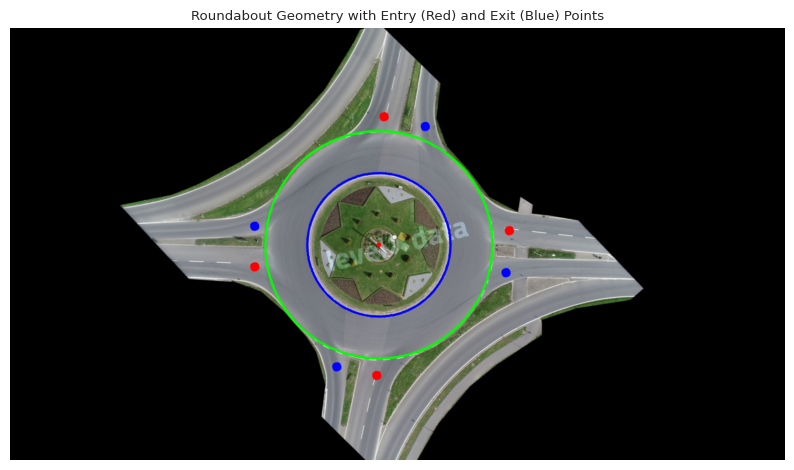

Filtering data with the following parameters:

Sampling period: 1000 ms 

Frame spacing: 25 frames 

Processing dataset 15

Rotating image 14.955661550371733 degrees counterclockwise to align the roundabout arms with the x-axis.

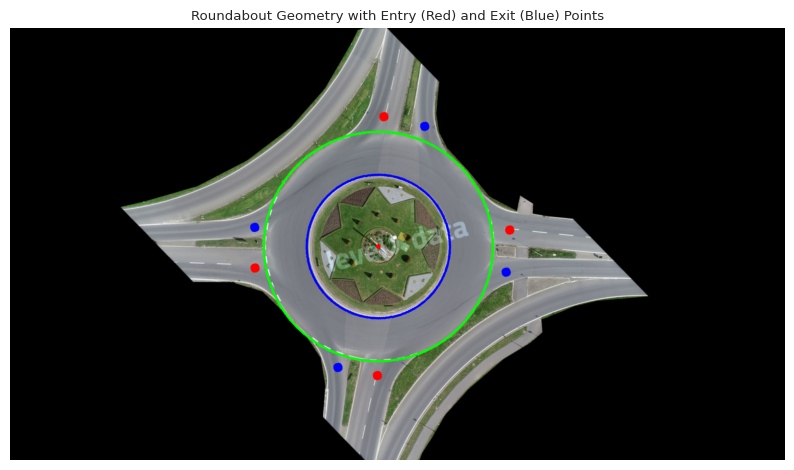

Filtering data with the following parameters:

Sampling period: 1000 ms 

Frame spacing: 25 frames 

Processing dataset 16

Rotating image 14.556472587632655 degrees counterclockwise to align the roundabout arms with the x-axis.

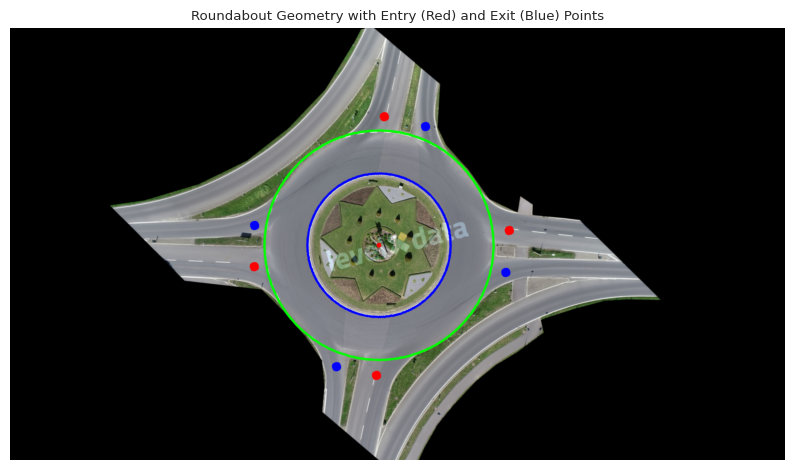

Filtering data with the following parameters:

Sampling period: 1000 ms 

Frame spacing: 25 frames 

Processing dataset 17

Rotating image 15.046567844000226 degrees counterclockwise to align the roundabout arms with the x-axis.

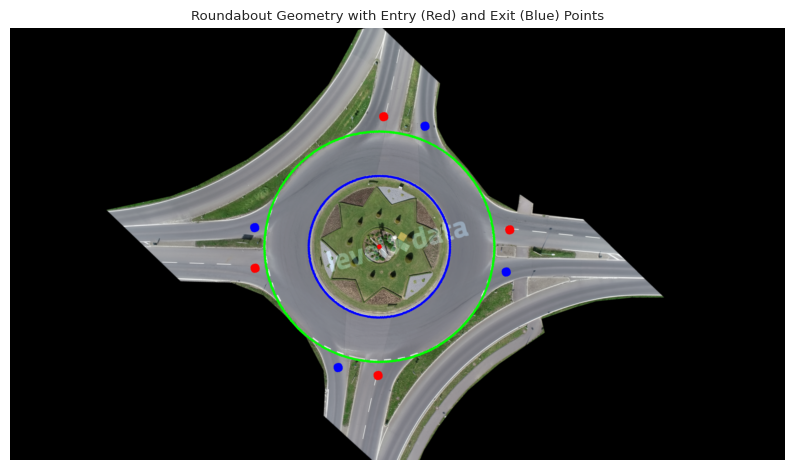

Filtering data with the following parameters:

Sampling period: 1000 ms 

Frame spacing: 25 frames 

Processing dataset 18

Rotating image 15.011273254575729 degrees counterclockwise to align the roundabout arms with the x-axis.

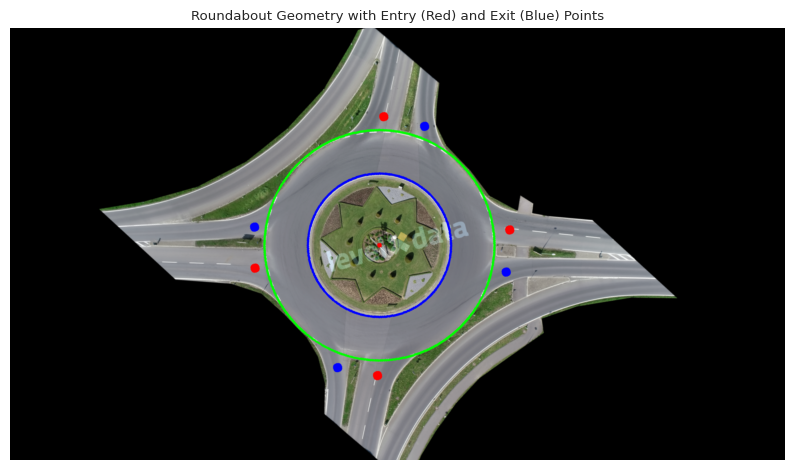

Filtering data with the following parameters:

Sampling period: 1000 ms 

Frame spacing: 25 frames 

Processing dataset 19

Rotating image 15.196084920766818 degrees counterclockwise to align the roundabout arms with the x-axis.

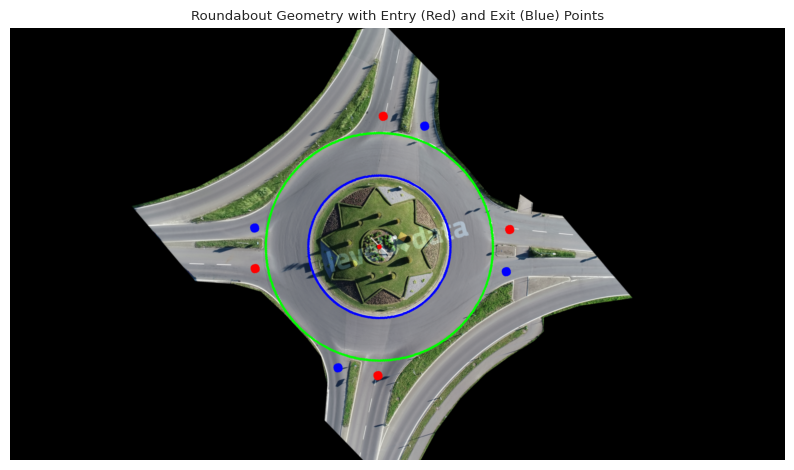

Filtering data with the following parameters:

Sampling period: 1000 ms 

Frame spacing: 25 frames 

Processing dataset 20

Rotating image 15.141360845412352 degrees counterclockwise to align the roundabout arms with the x-axis.

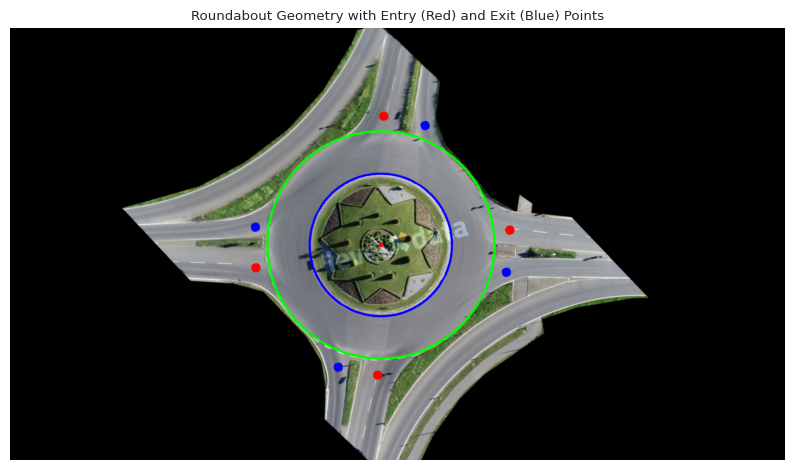

Filtering data with the following parameters:

Sampling period: 1000 ms 

Frame spacing: 25 frames 

Processing dataset 21

Rotating image 14.988450611759465 degrees counterclockwise to align the roundabout arms with the x-axis.

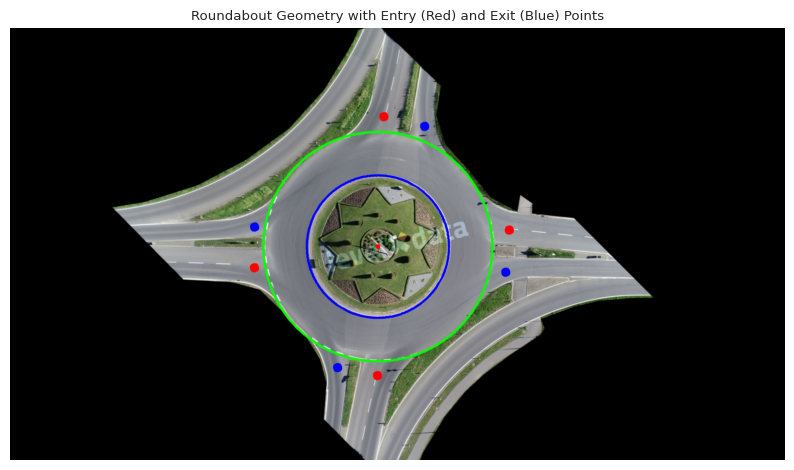

Filtering data with the following parameters:

Sampling period: 1000 ms 

Frame spacing: 25 frames 

Processing dataset 22

Rotating image 15.002063612477802 degrees counterclockwise to align the roundabout arms with the x-axis.

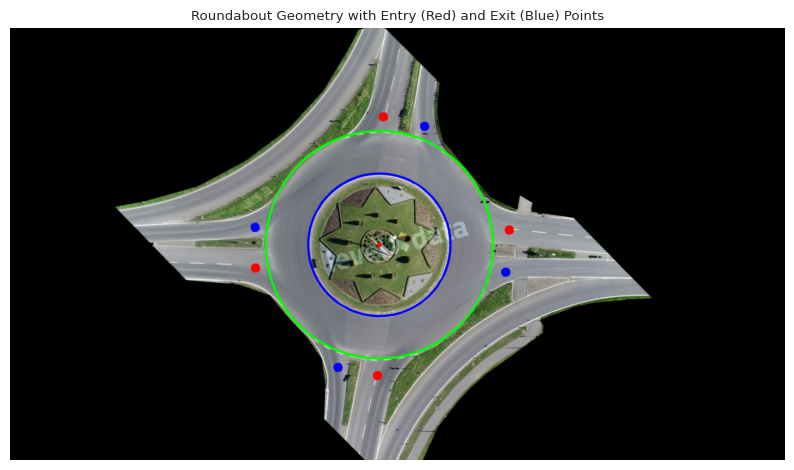

Filtering data with the following parameters:

Sampling period: 1000 ms 

Frame spacing: 25 frames 

In [25]:
if os.path.exists("/Users/lmiguelmartinez/Tesis/datasets/rounD/data/"):
    dataset_location = "/Users/lmiguelmartinez/Tesis/datasets/rounD/data/"
else:
    dataset_location = "/home/lmmartinez/Tesis/datasets/rounD/data/"

# dataset_index = 2
# print("Processing dataset", dataset_index)
# scene_data = RounDGroupExtractor(dataset_location=dataset_location, dataset_index=dataset_index)
# scene_data.get_roundabout_edges()    
# scene_data.get_entry_exit_points()
# scene_data.plot_roundabout_geometry_and_points(rotate=True)
# scene_data.filter_data(sampling_period=1000)
for dataset_index in range(1, 23):
    print("Processing dataset", dataset_index)
    scene_data = RounDGroupExtractor(dataset_location=dataset_location, dataset_index=dataset_index)
    scene_data.get_roundabout_edges()    
    scene_data.get_entry_exit_points()
    scene_data.plot_roundabout_geometry_and_points(rotate=True)
    scene_data.filter_data(sampling_period=1000)

In [20]:
scene_data.data.head()
print(scene_data.center_x_m, scene_data.center_y_m, scene_data.outer_radius_m, scene_data.inner_radius_m)

81.28121089327104 -46.83829777724743 25.19717537691402 15.849836124187851